In [54]:
import pandas as pd
# loads X train dataset (features of each instance)
x_train = pd.read_csv('CompleteDataSet/x_train_all.csv')
# load Y train dataset (classes of each instance)
y_train=pd.read_csv('CompleteDataSet/y_train_all.csv')

x_train.shape

(9690, 2304)

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score,davies_bouldin_score,calinski_harabasz_score
from sklearn.metrics import accuracy_score




In [56]:
# Function to get silhouette score
# takes dataframe and predicted labels as parameters
# returns silhouette score
def silhouetteScore(data, clustersdata):
    silhouette_avg = silhouette_score(data, clustersdata)
    print("Silhouette Score:", silhouette_avg)
    return silhouette_avg

In [180]:
def db_score(data, clustersdata):
    davies_bouldin = davies_bouldin_score(data, clustersdata)
    print("Davies-Bouldin Score:", davies_bouldin)
    return davies_bouldin

In [181]:
def calinski_score(data, clustersdata):
    calinski_harabasz = calinski_harabasz_score(data, clustersdata)
    print("Calinski-Harabasz Score:", calinski_harabasz)
    return calinski_harabasz

### Create Diff kinds of dataframe


##### PCA

In [57]:
n_components = 1500  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x_train)

pca1000 = PCA(n_components=1000)
X_pca1000 = pca1000.fit_transform(x_train)

pca2000 = PCA(n_components=2000)
X_pca2000 = pca2000.fit_transform(x_train)

# function to apply PCA on dataframe
# returns df with PCA applied
def PCAOnData(data,components):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(data)
    df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    return df_pca

##### Pre-Processed

In [58]:
processed_df = pd.read_csv('processed_df.csv')

##### Infra-Red


In [59]:
def grayscale_to_infrared(grayscale_image):
    row = np.array(grayscale_image, dtype=np.uint8)
    color_map = plt.get_cmap('hot')
    normalized_image = row / 255.0
    infrared_image = (color_map(normalized_image)[:, :, 0] * 255).astype(np.uint8)
    return infrared_image.flatten()

In [60]:
infrared_original = []

for i, idx in enumerate(x_train.index):
    original_image = x_train.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_org = pd.DataFrame(infrared_original)
infrared_df_org.shape

(9690, 2304)

In [61]:
infrared_df_org.to_csv("infrared_df_org.csv")

In [62]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in x_train.columns]
infrared_copy = x_train.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_no_outliers = infrared_copy.drop(outlier_indices)
infra_no_outliers.to_csv('x_train_no_outliers.csv',index=False)

outlier_indices_df = pd.DataFrame({'outlier_index': outlier_indices})

outlier_indices_df.to_csv('outlier_indices.csv', index=False)

In [63]:
y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train_no_outliers = y_train.drop(outlier_indices)

In [64]:
mean=infra_no_outliers.mean()
std=infra_no_outliers.std()
infra_norm=(infra_no_outliers-mean)/std

In [65]:
mean=x_train.mean()
std=x_train.std()
x_norm=(x_train-mean)/std

In [66]:
infrared_original = []

for i, idx in enumerate(x_norm.index):
    original_image = x_norm.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_norm = pd.DataFrame(infrared_original)
infrared_df_norm.shape

(9690, 2304)

In [67]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in infrared_df_norm.columns]
infrared_copy = infrared_df_norm.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_norm_no_outliers = infrared_copy.drop(outlier_indices)

In [68]:
import cv2
def apply_gaussian_blur(row, kernel_size=(5, 5), sigma=0):
    row = np.array(row, dtype=np.uint8)
    row = cv2.GaussianBlur(row, kernel_size, sigma)
    return row

def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

In [69]:
infrared_prep = []

for index, row in infra_norm_no_outliers.iterrows():
    image_data = row.values
    gaussian_image = apply_gaussian_blur(image_data)
    equalized_image = apply_clahe(gaussian_image)
    infrared_prep.append(equalized_image.flatten())

prepped_infrared_df = pd.DataFrame(infrared_prep)
prepped_infrared_df.shape

(9593, 2304)

In [70]:
image_df = prepped_infrared_df.copy()

In [71]:
import cv2
import pandas as pd
import numpy as np

# Assuming 'image_df' is your DataFrame with each row as an image

# Create a list to store the Fourier Transformed images
fourier_transformed_images = []

# Iterate through each row (image) in the DataFrame
for index, row in image_df.iterrows():
    # Convert the row (image) to a NumPy array
    image = row.values.reshape(48, 48)

    # Apply DFT to the image
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero frequency components to the center
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1])

    # Flatten the magnitude spectrum to 1D
    flattened_magnitude_spectrum = magnitude_spectrum.flatten()

    # Append the flattened magnitude spectrum to the list
    fourier_transformed_images.append(flattened_magnitude_spectrum)

# Create a new DataFrame from the Fourier Transformed images
fourier_df = pd.DataFrame(fourier_transformed_images)

# The 'fourier_df' DataFrame now contains the magnitude spectra of the images


In [72]:
fourier_df.shape

(9593, 2304)

In [73]:
image_df = fourier_df.copy()

In [74]:
import numpy as np
import cv2  # Make sure you have OpenCV installed

# Define a function to emphasize lower frequencies using DCT
def emphasize_lower_frequencies(image, keep_ratio=0.1):
    # Apply DCT
    dct = cv2.dct(np.float32(image))

    # Determine the threshold to retain keep_ratio of the coefficients
    sorted_dct = np.sort(np.abs(dct), axis=None)
    threshold = sorted_dct[int(keep_ratio * sorted_dct.size)]

    # Zero out high-frequency coefficients
    dct[np.abs(dct) < threshold] = 0

    # Apply inverse DCT to get the filtered image
    filtered_image = cv2.idct(dct)
    
    return filtered_image


In [75]:
image_df = prepped_infrared_df.copy()

filtered_images = []

for index, row in image_df.iterrows():
    image_data = row.values
    filtered_image = emphasize_lower_frequencies(image_data, keep_ratio=0.1)
    filtered_images.append(equalized_image.flatten())

filtered_df = pd.DataFrame(filtered_images)
filtered_df.shape

(9593, 2304)

In [76]:
image_df = prepped_infrared_df.copy()

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data_normalized = scaler.fit_transform(image_df)

In [78]:
import cv2

def apply_median_filter(image, kernel_size=37):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_blur_cv(image, kernel_size=(15, 15)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_bilateral_filter(image, diameter=25, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

In [79]:
image_df = prepped_infrared_df.copy()
infrared_prep2 = []

for index, row in image_df.iterrows():
    image_data = row.values
    median_image = apply_median_filter(image_data)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    median_image = apply_median_filter(gaussian_image)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    infrared_prep2.append(gaussian_image.flatten())

prepped_infrared_df2 = pd.DataFrame(infrared_prep2)
prepped_infrared_df2.shape

(9593, 2304)

In [80]:
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [81]:
iso_df = prepped_infrared_df2.copy()

In [153]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
iso_data = isomap.fit_transform(iso_df)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\mujta\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [83]:
pd.DataFrame(iso_data).to_csv("testing_df.csv")

In [84]:
def lp_intensify(arr, lower_percentile, upper_percentile):
    lower_limit = np.percentile(arr, lower_percentile)
    upper_limit = np.percentile(arr, upper_percentile)
    
    arr[arr < lower_limit] = 0
    arr[arr > upper_limit] = 255
    
    return arr

data = iso_data.copy()
lower_frequency_data = lp_intensify(data, 87, 90)

In [27]:
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [42]:
infrared_df_norm.to_csv("infrared_df_norm.csv")
infra_norm_no_outliers.to_csv("infra_norm_no_outliers.csv")
prepped_infrared_df.to_csv("prepped_infrared_df.csv")



### Visualise


In [85]:
# Function to plot T-SNE graphs.
# Takes the dataframe,predicted labels and title of graph as parameters
# Plots graph
def TSNEplots(data,clusterlabels,title):
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)

    dataTSNE = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

In [205]:
def accuracy_metric(y_train, cluster_labels):
    data = []
    labels = []
    

    for cluster_label in np.unique(cluster_labels):
        cluster_mask = (cluster_labels == cluster_label)
        # X_cluster = testing_df[cluster_mask]
        y_cluster = y_train[cluster_mask].flatten()
        majority_class = np.bincount(y_cluster).argmax()

        for unique_class in y_cluster:
            class_size = np.sum(y_cluster == unique_class)

        # data.append(X_cluster)
        labels.append(y_cluster)

    # data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels)
        
    accuracy = accuracy_score(y_train, labels)
    print("Accuracy:", accuracy)
    return accuracy

### Create Clustering Algos


In [213]:
from sklearn.cluster import DBSCAN,AgglomerativeClustering,Birch

##### Agglomerative Clustering

In [214]:
# function to apply AgglomerativeClustering on df
# takes df and num of clusters as parameters
# returns predicted labels
def aggfunc(data, k):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    clusters = agg_clustering.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [215]:
# apply clustering algorithm to df with 10 clusters
agg_10_clusters_labels = aggfunc(x_train,10) 

In [216]:
# obtain performance metrics
silhouetteScore(x_train,agg_10_clusters_labels)
calinski_score(x_train,agg_10_clusters_labels)
db_score(x_train,agg_10_clusters_labels)
# accuracy_metric(y_train,agg_10_clusters_labels)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1597.112499243934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9524809759953623


1.9524809759953623

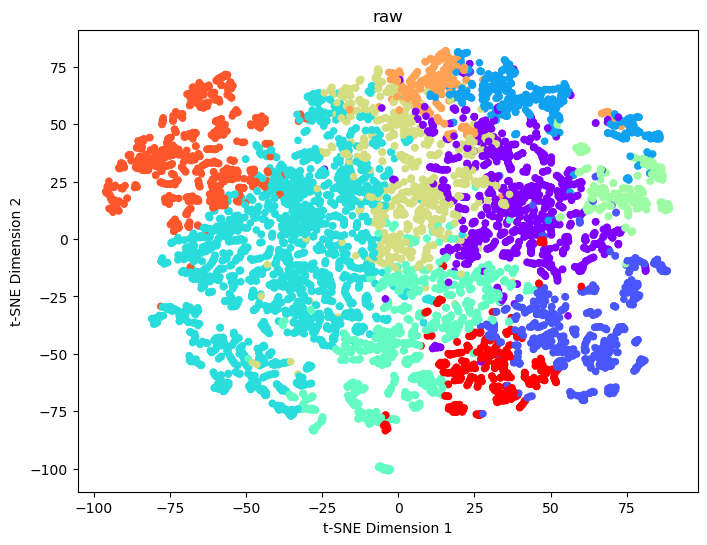

In [217]:
# plot TSNE graph
TSNEplots(x_train.to_numpy(),agg_10_clusters_labels,"raw") 

In [218]:
silhouetteScoreAllRaw = [] 
calinskiScoreAllRaw = [] 
dbScoreAllRaw = [] 

# for loop to obtain performance metrics with different numbers of clusters
#  Raw data
for i in range(2, 12): 
    # get labels with i number of clusters
    raw_labels_pred = aggfunc(x_train,i)
    # append score to list
    silhouetteScoreAllRaw.append(silhouetteScore(x_train,raw_labels_pred))
    calinskiScoreAllRaw.append(calinski_score(x_train,raw_labels_pred))
    dbScoreAllRaw.append(db_score(x_train,raw_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3532791090619684


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 4595.510066284532


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.3789135722248576


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1879831451772538


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 3197.6692861331653


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8304041614179738


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.19888231502242126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2790.919988531779


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8619384536687456


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.20393837995988515


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2418.3571166220827


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.0327382587060763


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.21153913098707894


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2203.1269219421993


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9168872501189604


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1983724831499671


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2028.2793183338324


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9092645516840467


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2006722206263219


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1852.2246596589362


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8994478351353612


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.0941067338452834


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1721.4703165392389


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8532997679676564


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1597.112499243934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9524809759953623


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08785947340116355


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1488.9296812366404


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.059806054400207


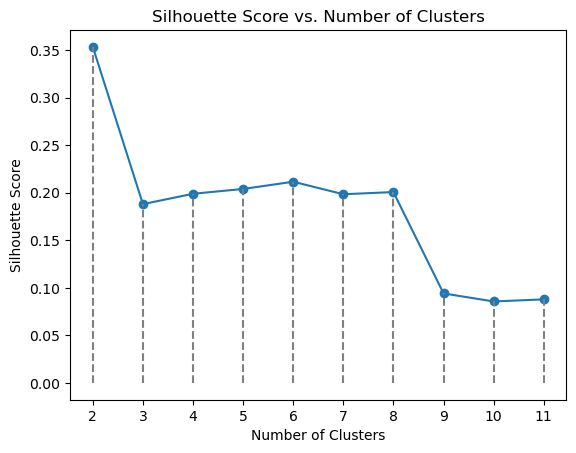

In [219]:
# Plot silhouette Scores against different number of clusters
# Raw data
cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllRaw, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllRaw[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [220]:
# apply clustering algorithm to df converted to infrared with 10 clusters
agg_10_clusters_labels_infra = aggfunc(infrared_df_org,10)

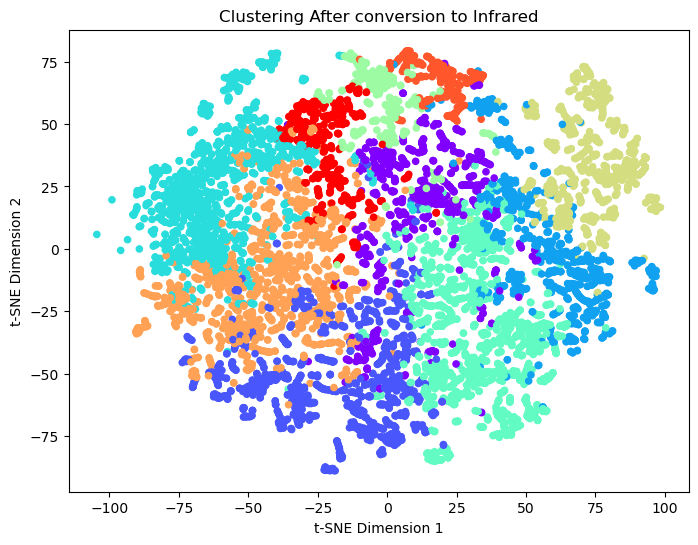

In [221]:
# plot TSNE graph
TSNEplots(infrared_df_org,agg_10_clusters_labels_infra,"Clustering After conversion to Infrared")

In [222]:
# obtain performance metrics
silhouetteScore(infrared_df_org,agg_10_clusters_labels_infra)
calinski_score(x_train,agg_10_clusters_labels)
db_score(x_train,agg_10_clusters_labels)
# accuracy_metric(y_train,agg_10_clusters_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.10424093019253086


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1597.112499243934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9524809759953623


1.9524809759953623

In [223]:
# apply clustering algorithm to df converted to infrared and no outliers with 10 clusters
clusters_infra_no_outliers = aggfunc(infra_no_outliers, 10)
# obtain performance metrics
silhouetteScore(infra_no_outliers,clusters_infra_no_outliers)
calinski_score(infra_no_outliers,clusters_infra_no_outliers)
db_score(infra_no_outliers,clusters_infra_no_outliers)
# accuracy_metric(y_train,clusters_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1516.0316693513314


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.105330645937184


2.105330645937184

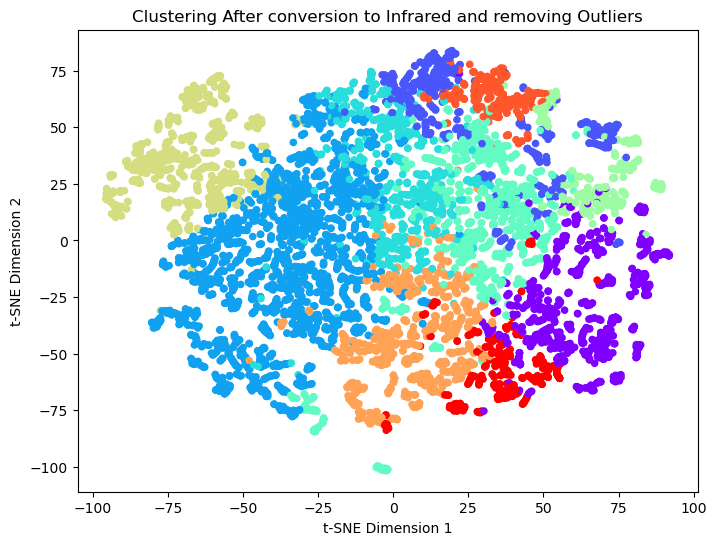

In [224]:
# plot TSNE graph
TSNEplots(infra_no_outliers,clusters_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [225]:
# apply Clustering After Normalisation with 10 clusters
clusters_infra_norm = aggfunc(infra_norm, 10)
# obtain performance metrics
silhouetteScore(infra_norm,clusters_infra_norm)
calinski_score(infra_norm,clusters_infra_norm)
db_score(infra_norm,clusters_infra_norm)
# accuracy_metric(y_train,clusters_infra_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08682438504803372


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1466.2636484034615


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.047624952777414


2.047624952777414

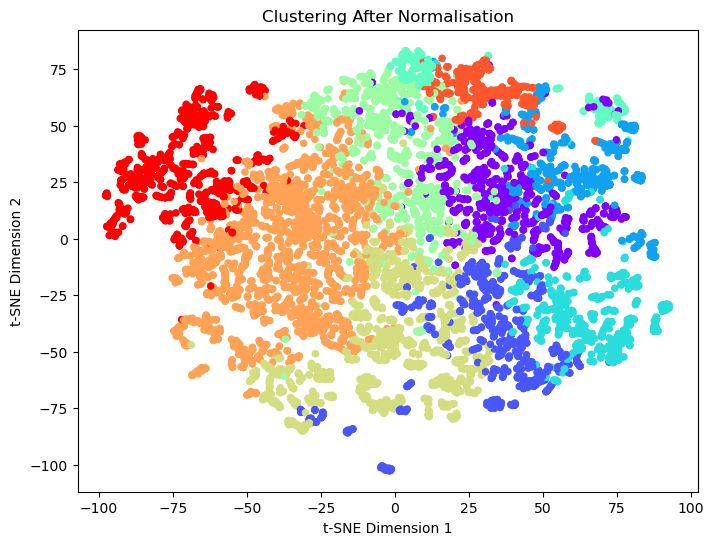

In [226]:
# plot TSNE graph
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After Normalisation")

In [227]:
# apply Clustering After first normalising and then applying Infrared conversion with 10 clusters
clusters_infrared_df_norm = aggfunc(infrared_df_norm, 10)
# obtain performance metric
silhouetteScore(infrared_df_norm,clusters_infrared_df_norm)
calinski_score(infrared_df_norm,clusters_infrared_df_norm)
db_score(infrared_df_norm,clusters_infrared_df_norm)
# accuracy_metric(y_train,clusters_infrared_df_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46254749032402126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1496.1553167352206


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.615637867182651


2.615637867182651

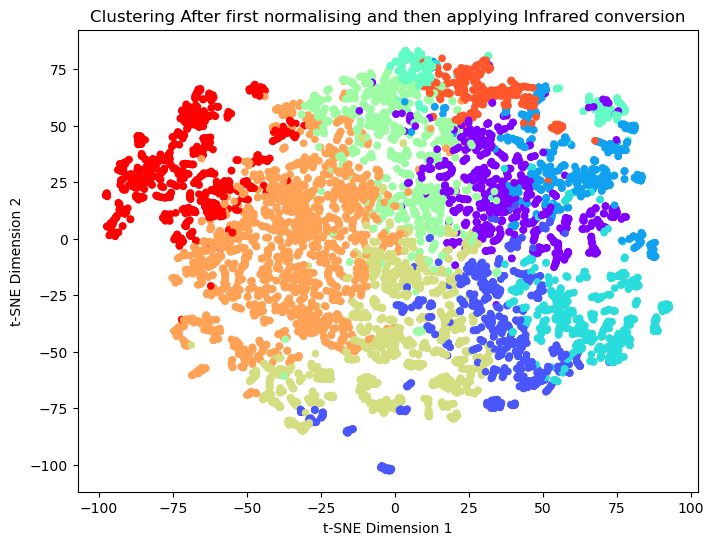

In [228]:
# plot TSNE graph
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After first normalising and then applying Infrared conversion")

In [229]:
# Clustering After removing Outliers with 10 clusters
clusters_infra_norm_no_outliers = aggfunc(infra_norm_no_outliers, 10)
# obtain performance metrics
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers)
calinski_score(infra_norm_no_outliers,clusters_infra_norm_no_outliers)
db_score(infra_norm_no_outliers,clusters_infra_norm_no_outliers)
accuracy_metric(y_train,clusters_infra_norm_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1267.3185223811015


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.5332983215861167
Accuracy: 0.1964974460544147


0.1964974460544147

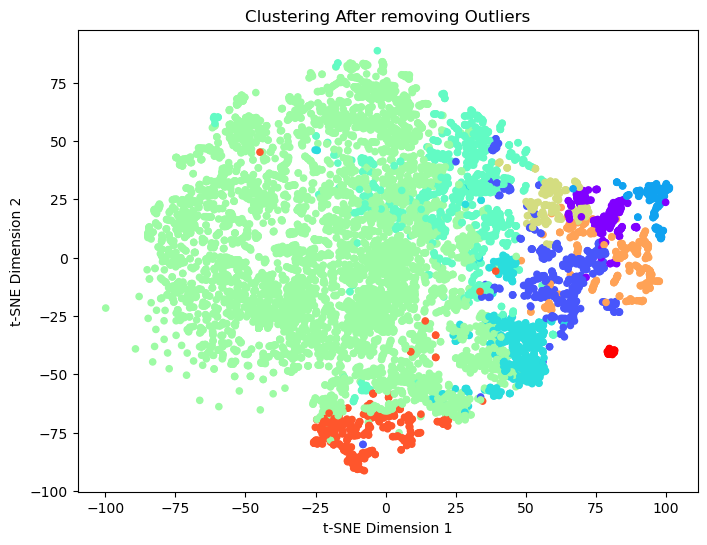

In [230]:
# plot TSNE graph
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers,"Clustering After removing Outliers")

In [231]:
silhouetteScoreAll = [] 

# for loop to obtain performance metrics with different numbers of clusters
# normalised and outlier mined data
for i in range(2, 15): 
    # get labels with i number of clusters
    clustersLabels = aggfunc(infra_norm_no_outliers,i)
    # append score to list
    silhouetteScoreAll.append(silhouetteScore(infra_norm_no_outliers,clustersLabels))


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6497470524049589


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.5993403350000828


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.602393660684713


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4670504658963724


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46815855705203424


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.47154068178230957


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.465090706813612


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4646668602861849


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46346324923462934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4633759228662821


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46489932057515354


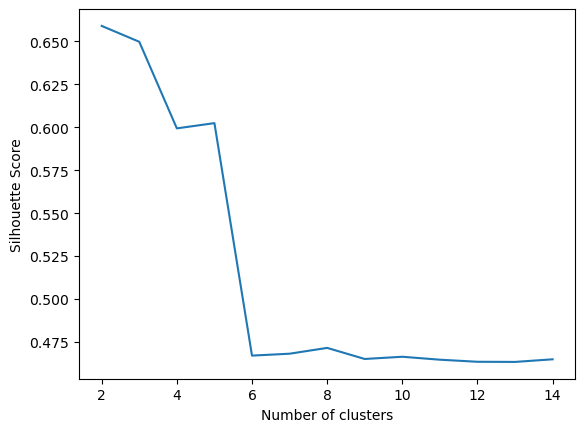

In [232]:
# Plot silhouette Scores against different number of clusters
plt.plot(range(2, 15), silhouetteScoreAll)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
plt.show()

In [233]:
# Clustering After removing Outliers with 2 clusters
clusters_infra_norm_no_outliers_2 = aggfunc(infra_norm_no_outliers, 2)
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2)
calinski_score(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2)
db_score(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2)
accuracy_metric(y_train,clusters_infra_norm_no_outliers_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 5467.143129888462


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.1788139171389898
Accuracy: 0.44396956113833


0.44396956113833

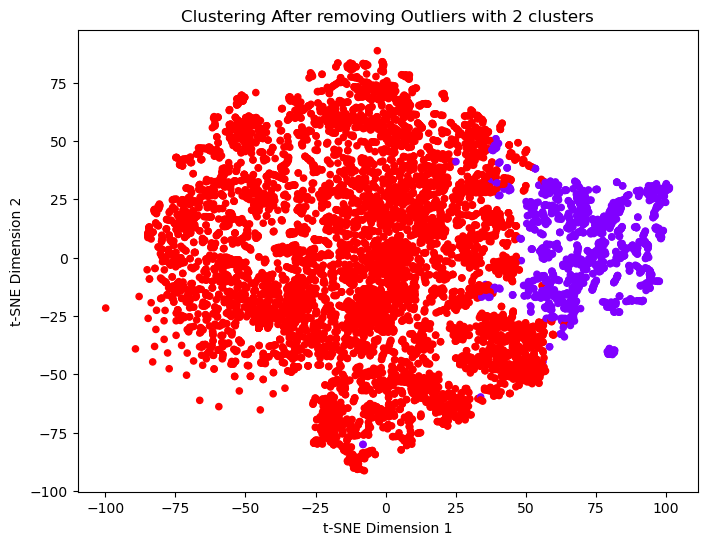

In [234]:
# plot graph
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [235]:
# Clustering After Preprocessing with 10 clusters
clusters_preprocessed = aggfunc(prepped_infrared_df, 10)
# obtain performance metric

silhouetteScore(prepped_infrared_df,clusters_preprocessed)
calinski_score(prepped_infrared_df,clusters_preprocessed)
db_score(prepped_infrared_df,clusters_preprocessed)
accuracy_metric(y_train,clusters_preprocessed)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.44571711187269836


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1901.8428499428112


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.2392080976136723
Accuracy: 0.09517356405712499


0.09517356405712499

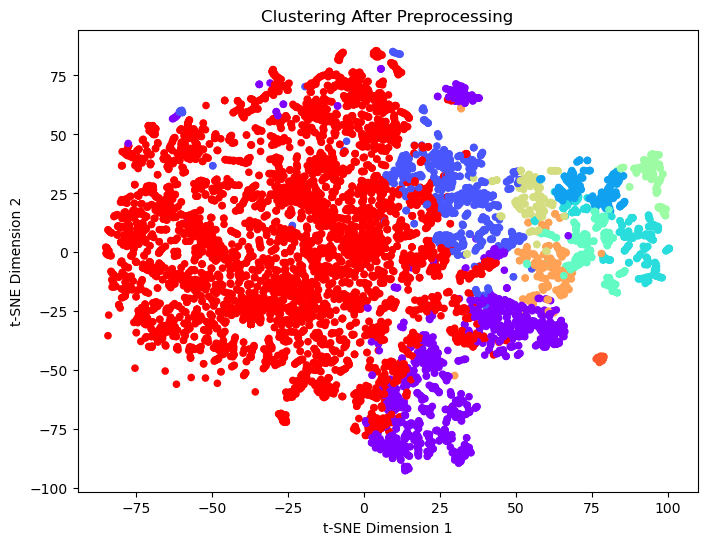

In [236]:
# plot graph
TSNEplots(prepped_infrared_df,clusters_preprocessed,"Clustering After Preprocessing")

In [237]:
# Clustering After Preprocessing (2 clusters)
clusters_preprocessed_2 = aggfunc(prepped_infrared_df, 2)
# obtain performance metric
silhouetteScore(prepped_infrared_df,clusters_preprocessed_2)
calinski_score(prepped_infrared_df,clusters_preprocessed_2)
db_score(prepped_infrared_df,clusters_preprocessed_2)
accuracy_metric(y_train,clusters_preprocessed_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 7498.772943453889


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.0104875046192914
Accuracy: 0.453351402064005


0.453351402064005

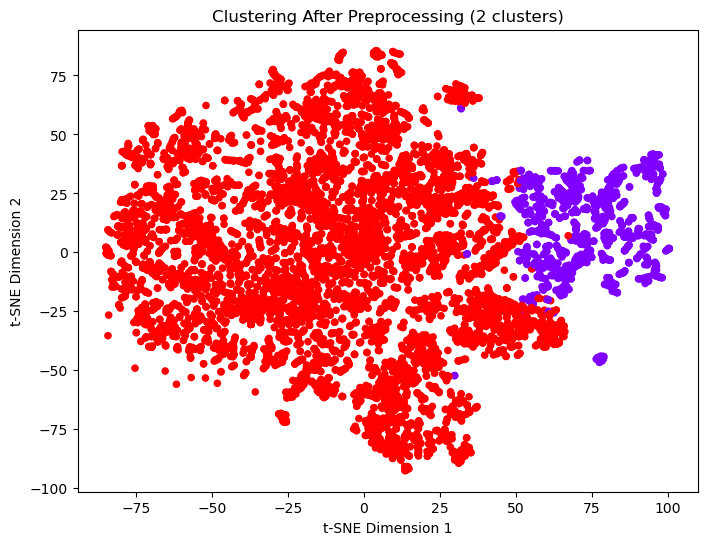

In [238]:
# plot graph
TSNEplots(prepped_infrared_df,clusters_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [239]:
# apply pca on pre-processed data with 50 Components
df_pca_50 = PCAOnData(prepped_infrared_df, 50)
# apply clustering on df_pca_50 with 10 clusters
clusters_pca50 = aggfunc(df_pca_50, 10)
silhouetteScore(df_pca_50, clusters_pca50)
calinski_score(df_pca_50, clusters_pca50)
db_score(df_pca_50, clusters_pca50)
accuracy_metric(y_train,clusters_pca50)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4858482034036653
Calinski-Harabasz Score: 2619.3401183402343
Davies-Bouldin Score: 1.8968379238542823
Accuracy: 0.15678098613572397


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.15678098613572397

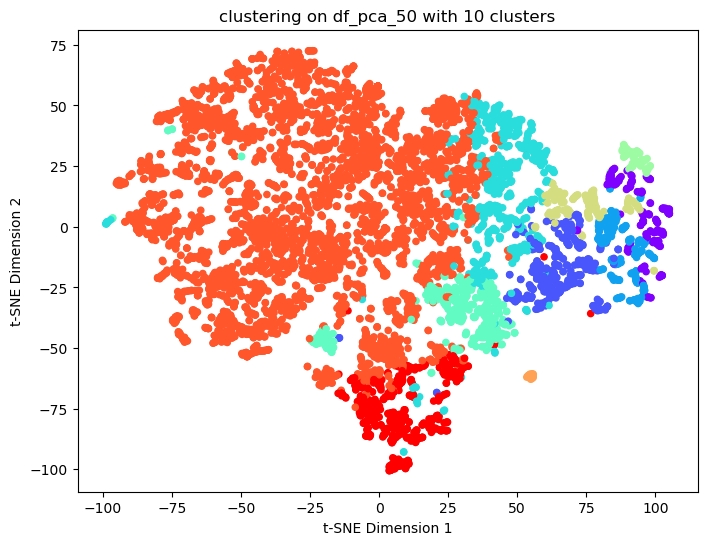

In [240]:
TSNEplots(df_pca_50,clusters_pca50,"clustering on df_pca_50 with 10 clusters")

In [241]:
# apply clustering on double processed data with 10 clusters
clusters = aggfunc(prepped_infrared_df2, 10)
silhouetteScore(prepped_infrared_df2, clusters)
calinski_score(prepped_infrared_df2, clusters)
db_score(prepped_infrared_df2, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.786266646588159


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 6076.8279442512
Davies-Bouldin Score: 1.4358112383574917


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.4358112383574917

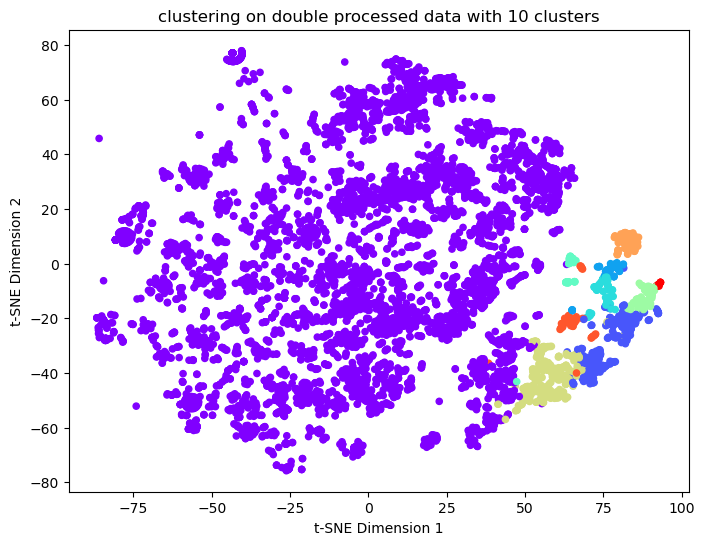

In [242]:
TSNEplots(prepped_infrared_df2,clusters,"clustering on double processed data with 10 clusters")

In [243]:
# apply clustering on double processed data with 2 clusters
clusters = aggfunc(prepped_infrared_df2, 2)
silhouetteScore(prepped_infrared_df2, clusters)
calinski_score(prepped_infrared_df, clusters)
db_score(prepped_infrared_df, clusters)
accuracy_metric(y_train,clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8742551748144332


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 3688.457373174936
Davies-Bouldin Score: 0.7746613592122991


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8122589388095486


0.8122589388095486

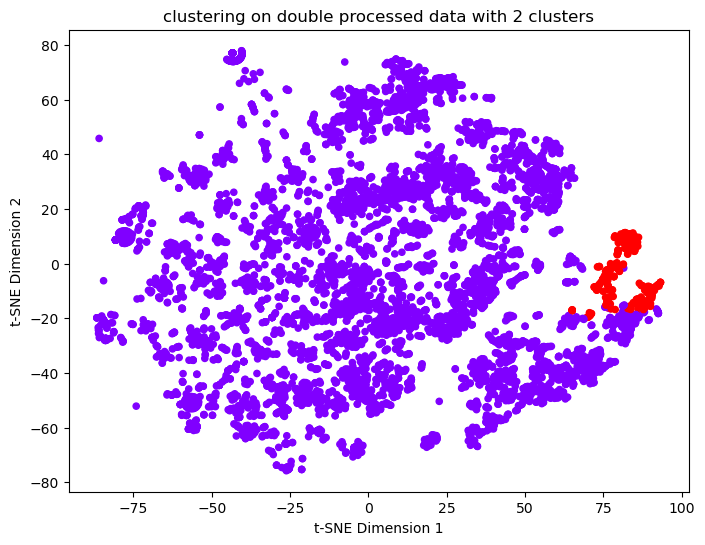

In [244]:
TSNEplots(prepped_infrared_df2,clusters,"clustering on double processed data with 2 clusters")

In [245]:
# apply pca on double pre-processed data with 50 Components
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [247]:
# apply clustering on pca_50 with 10 clusters and obtain performance metric
clusters = aggfunc(pca_50, 10)


In [248]:
silhouetteScore(pca_50, clusters)
calinski_score(pca_50, clusters)
db_score(pca_50, clusters)
# accuracy_metric(y_train,pca_50)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7864423075976492
Calinski-Harabasz Score: 6618.983206071436
Davies-Bouldin Score: 1.428225044791573


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.428225044791573

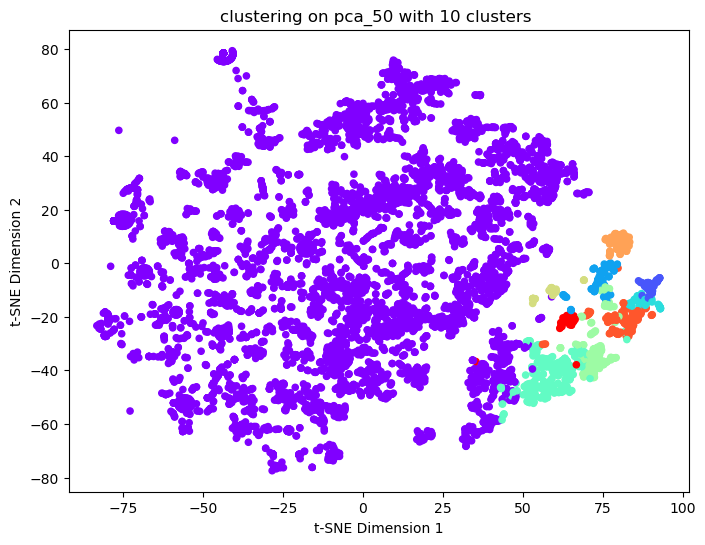

In [249]:
TSNEplots(pca_50,clusters,"clustering on pca_50 with 10 clusters ")

In [250]:
# apply clustering on pca_50 with 5 clusters and obtain performance metric
clusters = aggfunc(pca_50, 5)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7891984287574587


0.7891984287574587

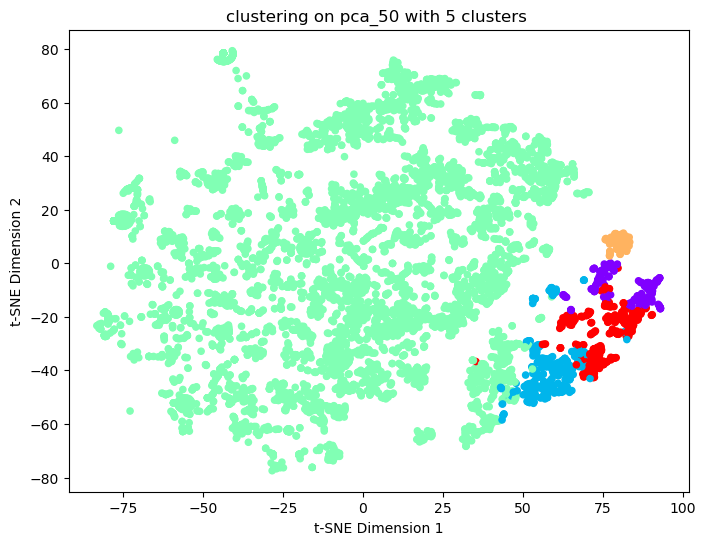

In [251]:
TSNEplots(pca_50,clusters,"clustering on pca_50 with 5 clusters ")

In [252]:
# apply pca on double pre-processed data with 3 Components
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [253]:
# apply clustering on pca_3 with 2 clusters and obtain performance metric
clusters = aggfunc(pca_50, 2)
silhouetteScore(pca_50, clusters)
calinski_score(pca_50, clusters)
db_score(pca_50, clusters)
# accuracy_metric(y_train,pca_3)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8774019713795597
Calinski-Harabasz Score: 11249.3863134692
Davies-Bouldin Score: 0.576779264788899


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.576779264788899

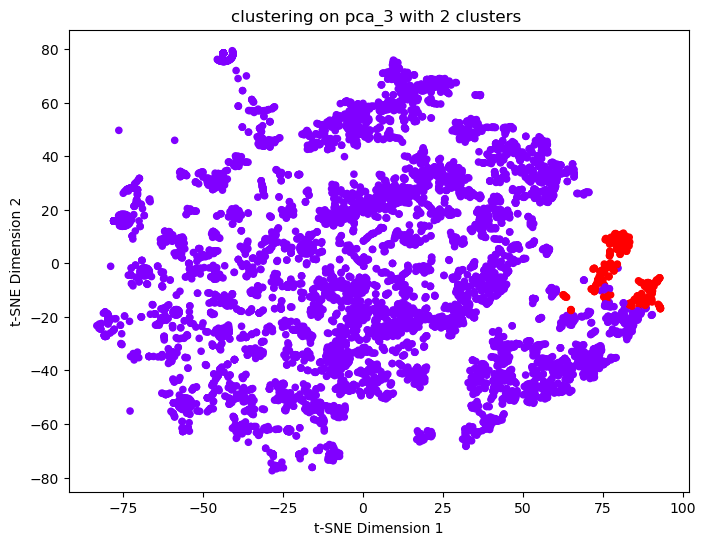

In [254]:
TSNEplots(pca_50,clusters,"clustering on pca_3 with 2 clusters ")

C:\Users\mujta\AppData\Local\Temp\ipykernel_22544\2551551981.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)


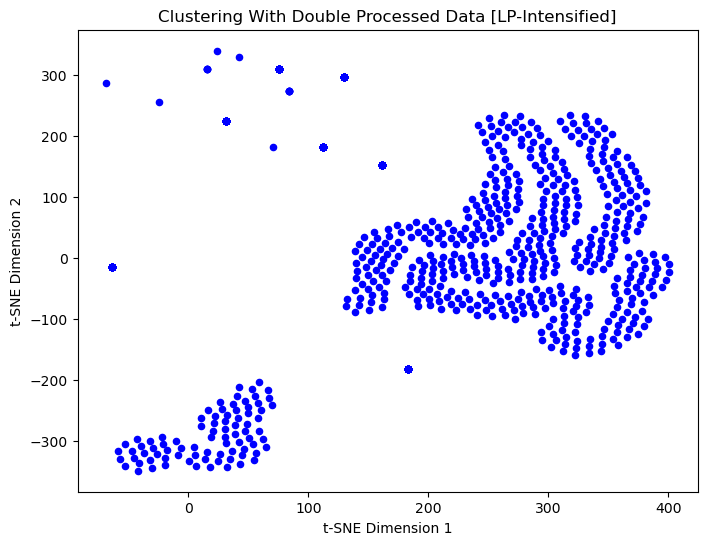

In [255]:
# plot T-SNE graph for Clustering With Double Processed Data [LP-Intensified]
TSNEplots(lower_frequency_data.copy(),'b',"Clustering With Double Processed Data [LP-Intensified]")

In [256]:
silhouetteScoreAll = [] 
calinskiScoreAllproc = [] 
dbScoreAllproc = [] 
# obtain performance metrics for final processed data by applying clustering for various number of clusters
lfd = lower_frequency_data.copy()
for i in range(2, 12): 
    
    clustersLabels = aggfunc(lfd,i)
    silhouetteScoreAll.append(silhouetteScore(lfd,clustersLabels))
    calinskiScoreAllproc.append(calinski_score(lfd,clustersLabels))
    dbScoreAllproc.append(db_score(lfd,clustersLabels))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8219683117859207
Calinski-Harabasz Score: 10855.467884358704
Davies-Bouldin Score: 0.2713495768922176


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9559656747743788
Calinski-Harabasz Score: 57959.36416592193
Davies-Bouldin Score: 0.3318861459335756


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9903732291634489
Calinski-Harabasz Score: 1204679.930237548
Davies-Bouldin Score: 0.056269597108028285


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9708006803981309
Calinski-Harabasz Score: 4727796.817368369
Davies-Bouldin Score: 0.13952311222031874


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9726766616035923
Calinski-Harabasz Score: 11664393.089268846
Davies-Bouldin Score: 0.23467400712448924


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9696134690118222
Calinski-Harabasz Score: 14702594.33053208
Davies-Bouldin Score: 0.26014577609947215


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9725839252383139
Calinski-Harabasz Score: 22477777.829003192
Davies-Bouldin Score: 0.2746428908097664


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.97243300225601
Calinski-Harabasz Score: 25739158.468730252
Davies-Bouldin Score: 0.24509852574463642


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.972801141885004
Calinski-Harabasz Score: 29970960.582749717
Davies-Bouldin Score: 0.2671581204571224


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9713207248330823
Calinski-Harabasz Score: 36707663.399280794
Davies-Bouldin Score: 0.28771209349560595


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


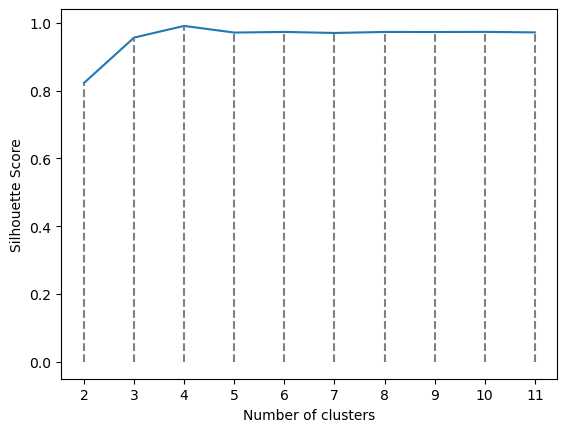

In [257]:
# plot comparison 
plt.plot(range(2, 12), silhouetteScoreAll)
plt.xticks(range(2, 12))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
clusterRange = range(2, 12)
for i in clusterRange:
    index = i - 2
    plt.plot([clusterRange[index], clusterRange[index]], [0, silhouetteScoreAll[index]], linestyle='--', color='gray')

plt.show()

In [258]:
# create copy iso_data
testing_df = iso_data.copy()
# remove outliers from y_train
y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train = y_train.drop(outlier_indices)
y_train = np.asarray(y_train)
# apply clustering
cluster_labels = aggfunc(testing_df,10)


In [259]:
# obtain performance metrics
silhouetteScore(testing_df,cluster_labels)
calinski_score(testing_df,cluster_labels)
db_score(testing_df,cluster_labels)
accuracy_metric(y_train,cluster_labels)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8309131451850831
Calinski-Harabasz Score: 20268.863769804502
Davies-Bouldin Score: 0.8593132086693576
Accuracy: 0.6569373501511518


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6569373501511518

In [260]:
testing_df.shape

(9593, 2)

In [261]:
y_train.shape

(9593, 1)

In [262]:
# get accuracy
accuracy= accuracy_metric(y_train,cluster_labels)
accuracy

Accuracy: 0.6569373501511518


0.6569373501511518

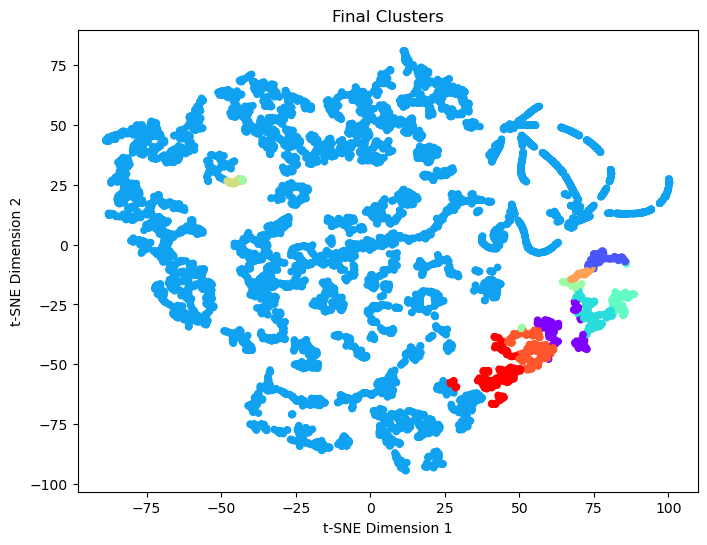

In [263]:
# plot TSNE graph
TSNEplots(testing_df,cluster_labels,"Final Clusters")

In [264]:
# obtain values of performance metrics on various clusters
raw_scores = silhouetteScoreAllRaw[::2]
processed_scores = silhouetteScoreAll[::2]
silhouette_bf = [raw_scores,processed_scores[0:5]]
calinski_bf = [calinskiScoreAllRaw[::2],(calinskiScoreAllproc[::2])[0:5]]
davies_bouldin_bf = [dbScoreAllRaw[::2],(dbScoreAllproc[::2])[0:5]]

### Comparision

In [265]:
x_axis = ["Raw", "After Pre-processing"]
y_axis = ["2 Clusters", "4 Clusters", "6 Clusters", "8 Clusters", "10 Clusters"] 
pd.DataFrame(silhouette_bf, x_axis, y_axis)

2 Clusters  4 Clusters  6 Clusters  8 Clusters  \
Raw                     0.353279    0.198882    0.211539    0.200672   
After Pre-processing    0.821968    0.990373    0.972677    0.972584   

                      10 Clusters  
Raw                      0.085637  
After Pre-processing     0.972801

In [266]:
pd.DataFrame(calinski_bf, x_axis, y_axis)

2 Clusters    4 Clusters    6 Clusters    8 Clusters  \
Raw                    4595.510066  2.790920e+03  2.203127e+03  1.852225e+03   
After Pre-processing  10855.467884  1.204680e+06  1.166439e+07  2.247778e+07   

                       10 Clusters  
Raw                   1.597112e+03  
After Pre-processing  2.997096e+07

In [267]:
pd.DataFrame(davies_bouldin_bf, x_axis, y_axis)

2 Clusters  4 Clusters  6 Clusters  8 Clusters  \
Raw                     1.378914    1.861938    1.916887    1.899448   
After Pre-processing    0.271350    0.056270    0.234674    0.274643   

                      10 Clusters  
Raw                      1.952481  
After Pre-processing     0.267158

## Birch Clustering

In [268]:
from sklearn.cluster import Birch


In [269]:
# function to apply Birch clustering on df
# takes df and num of clusters as parameters
# returns predicted labels
def birchfunc(data,n_clusters):
    brc = Birch(threshold=0.3, branching_factor=50,n_clusters=n_clusters)
    clusters = brc.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [270]:
testing_df.shape

(9593, 2)

In [271]:
# apply clustering algorithm to df with 10 clusters
birch_labels_raw = birchfunc(x_train,10)

In [272]:
# obtain performance metrics
silhouetteScore(x_train,birch_labels_raw)
calinski_score(x_train,birch_labels_raw)
db_score(x_train,birch_labels_raw)
# accuracy_metric(y_train,birch_labels_raw)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1597.112499243934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9524809759953623


1.9524809759953623

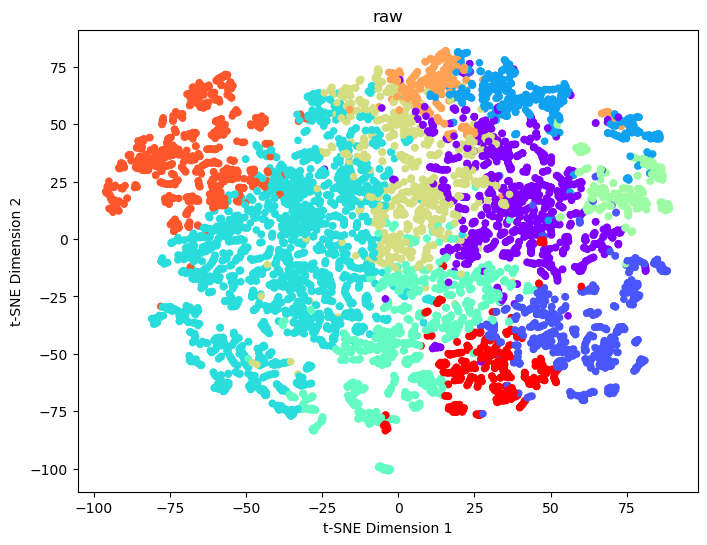

In [273]:
# plot TSNE graph
TSNEplots(x_train.to_numpy(),birch_labels_raw,"raw")

In [274]:
# apply clustering algorithm to df converted to infrared with 10 clusters
birch_labels_infra = birchfunc(infrared_df_org,10)

In [275]:
# obtain performance metrics

silhouetteScore(infrared_df_org,birch_labels_infra)
calinski_score(infrared_df_org,birch_labels_infra)
db_score(infrared_df_org,birch_labels_infra)
# accuracy_metric(y_train,birch_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08663277382574622


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1802.9193247464298


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.395723520061473


2.395723520061473

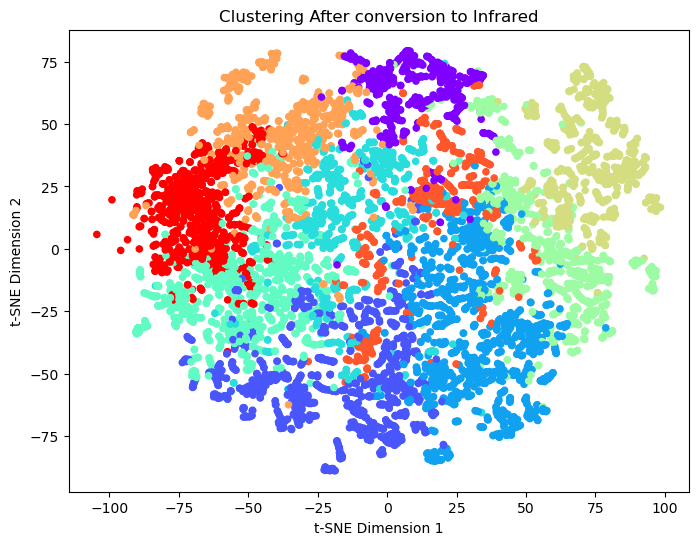

In [276]:
# plot TSNE graph
TSNEplots(infrared_df_org,birch_labels_infra,"Clustering After conversion to Infrared")

In [277]:
# apply clustering algorithm to df converted to infrared and no outliers with 10 clusters
birch_labels_infra_no_outliers = birchfunc(infra_no_outliers, 10)

In [278]:
# obtain performance metrics
silhouetteScore(infra_no_outliers,birch_labels_infra_no_outliers)
calinski_score(infra_no_outliers,birch_labels_infra_no_outliers)
db_score(infra_no_outliers,birch_labels_infra_no_outliers)
# accuracy_metric(y_train,birch_labels_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1516.0316693513314


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.105330645937184


2.105330645937184

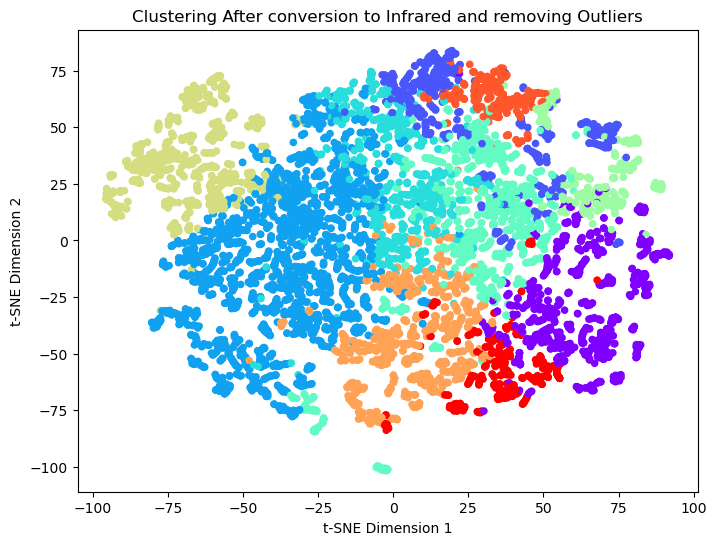

In [279]:
# plot TSNE graph
TSNEplots(infra_no_outliers,birch_labels_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [280]:
# apply Clustering After first normalising and then applying Infrared conversion with 10 clusters
birch_labels_infrared_df_norm = birchfunc(infrared_df_norm, 10)

In [281]:
# obtain performance metric
silhouetteScore(infrared_df_norm,birch_labels_infrared_df_norm)
calinski_score(infrared_df_norm,birch_labels_infrared_df_norm)
db_score(infrared_df_norm,birch_labels_infrared_df_norm)
# accuracy_metric(y_train,birch_labels_infrared_df_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.458620855793364


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1494.1249562313826


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.6350221825730946


2.6350221825730946

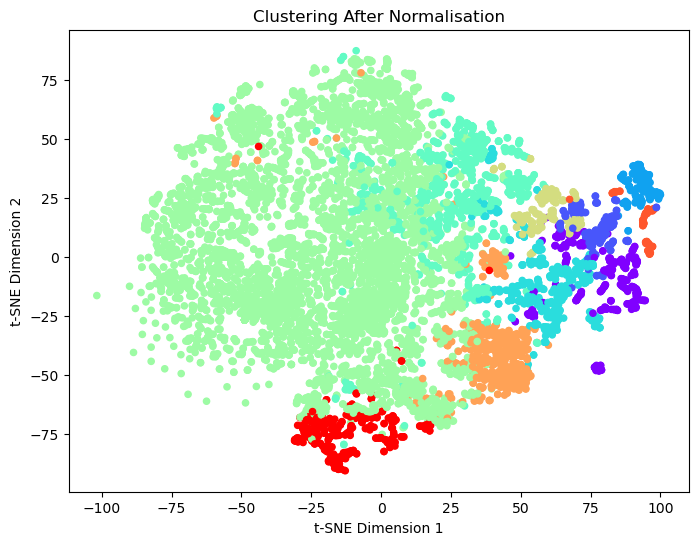

In [282]:
# plot TSNE graph
TSNEplots(infrared_df_norm,birch_labels_infrared_df_norm,"Clustering After Normalisation")

In [283]:
# Clustering After removing Outliers with 10 clusters
birch_labels_infrared_norm_no_outliers = birchfunc(infra_norm_no_outliers, 10)

In [284]:
# obtain performance metrics

silhouetteScore(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers)
calinski_score(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers)
db_score(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers)
# accuracy_metric(y_train,birch_labels_infrared_norm_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46317318567556964


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1269.2360326500677
Davies-Bouldin Score: 2.4654455972051394


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2.4654455972051394

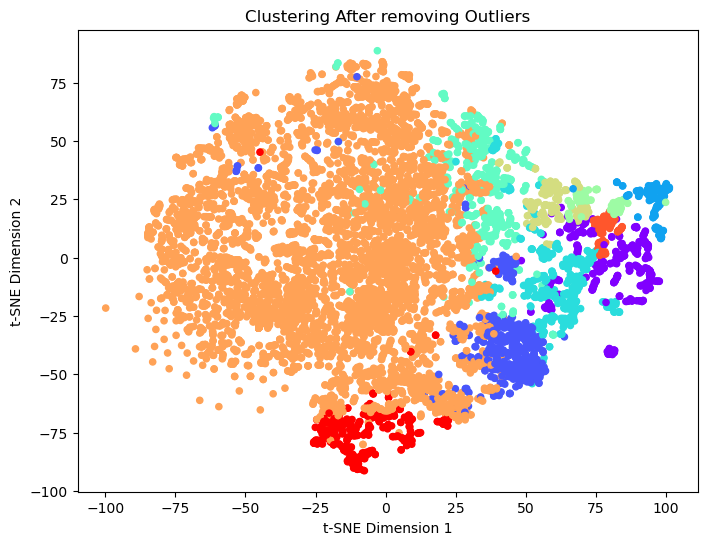

In [285]:
# plot TSNE graph
TSNEplots(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers,"Clustering After removing Outliers")

In [286]:
# Clustering After removing Outliers with 2 clusters
birch_infra_norm_no_outliers_2 = birchfunc(infra_norm_no_outliers, 2)


In [287]:
# apply silhouetteScore
silhouetteScore(infra_norm_no_outliers,birch_infra_norm_no_outliers_2)
calinski_score(infra_norm_no_outliers,birch_infra_norm_no_outliers_2)
db_score(infra_norm_no_outliers,birch_infra_norm_no_outliers_2)
# accuracy_metric(y_train,birch_infra_norm_no_outliers_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6573862940971725


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 5428.526033730185
Davies-Bouldin Score: 1.1846113147761654


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.1846113147761654

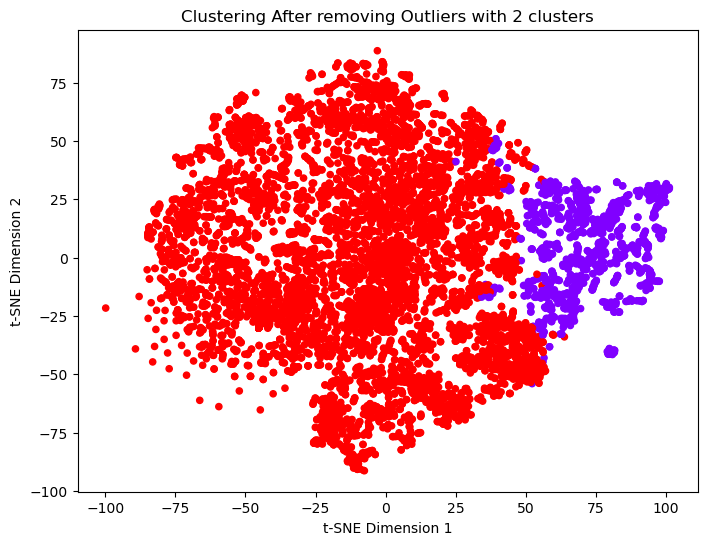

In [288]:
# plot graph
TSNEplots(infra_norm_no_outliers,birch_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [289]:
# Clustering After Preprocessing with 10 clusters
birch_preprocessed = birchfunc(prepped_infrared_df, 10)


In [290]:
# obtain performance metric
silhouetteScore(prepped_infrared_df,birch_preprocessed)
calinski_score(prepped_infrared_df,birch_preprocessed)
db_score(prepped_infrared_df,birch_preprocessed)
# accuracy_metric(y_train,birch_preprocessed)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.44851693459266523


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1907.1654270104293


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.231590795232904


2.231590795232904

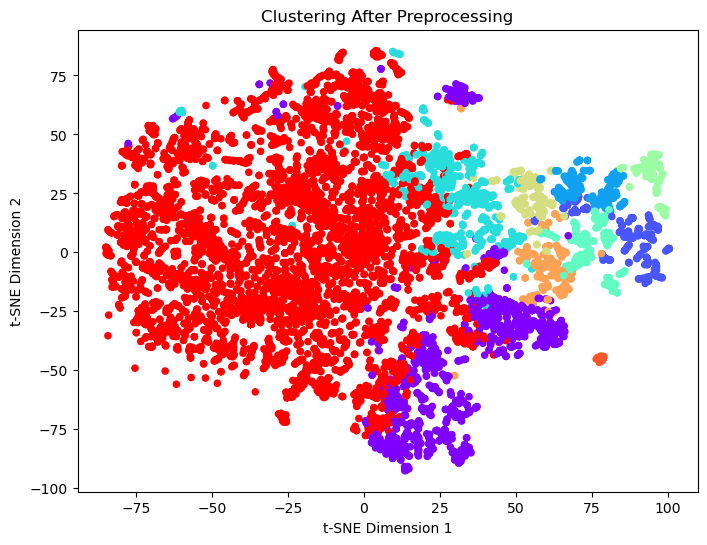

In [291]:
# plot graph
TSNEplots(prepped_infrared_df,birch_preprocessed,"Clustering After Preprocessing")

In [292]:
# Clustering After Preprocessing (2 clusters)
birch_preprocessed_2 = birchfunc(prepped_infrared_df, 2)


In [293]:
# obtain performance metric
silhouetteScore(prepped_infrared_df,birch_preprocessed_2)
calinski_score(prepped_infrared_df,birch_preprocessed_2)
db_score(prepped_infrared_df,birch_preprocessed_2)
# accuracy_metric(y_train,birch_preprocessed_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6861756694384897


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 7490.913647244389
Davies-Bouldin Score: 1.012321102594617


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.012321102594617

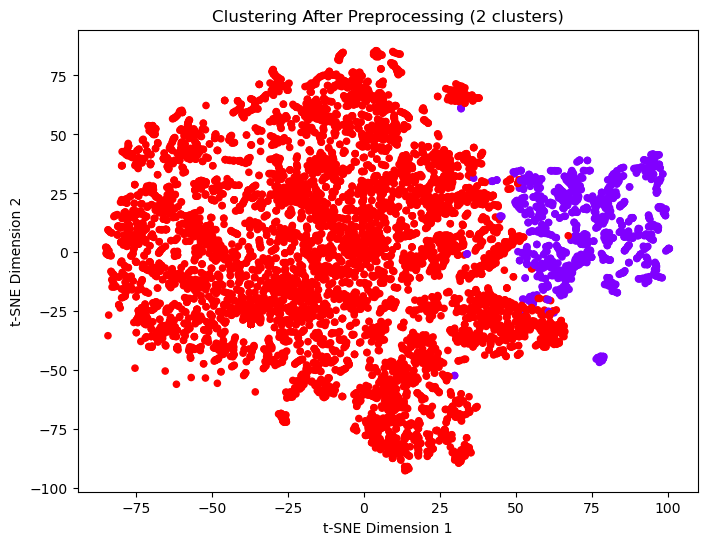

In [294]:
# plot graph
TSNEplots(prepped_infrared_df,birch_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [295]:
# apply clustering to final df
birch_labels_final = birchfunc(testing_df,10)

In [296]:
silhouetteScore(testing_df,birch_labels_final)
calinski_score(testing_df,birch_labels_final)
db_score(testing_df,birch_labels_final)
# accuracy_metric(y_train,birch_labels_final)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8309131451850831
Calinski-Harabasz Score: 20268.863769804502
Davies-Bouldin Score: 0.8593132086693576


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8593132086693576

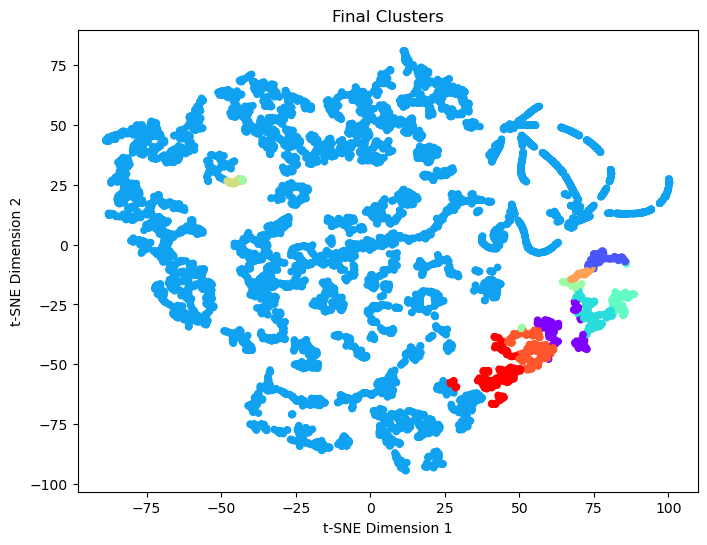

In [297]:
# plot TSNE graph
TSNEplots(testing_df,birch_labels_final,"Final Clusters")


In [298]:
# get accuracy
accuracy= accuracy_metric(y_train,birch_labels_final)


Accuracy: 0.6569373501511518


In [299]:
# apply clustering to lowered freq data df
birch_labels_final = birchfunc(lower_frequency_data.copy(),10)

In [300]:
# obtain performance metric
silhouetteScore(lower_frequency_data.copy(),birch_labels_final)
calinski_score(lower_frequency_data.copy(),birch_labels_final)
db_score(lower_frequency_data.copy(),birch_labels_final)
accuracy_metric(y_train,birch_labels_final)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.974089196133536
Calinski-Harabasz Score: 27472302.127890006
Davies-Bouldin Score: 0.21585643191605594
Accuracy: 0.5058897112477848


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5058897112477848

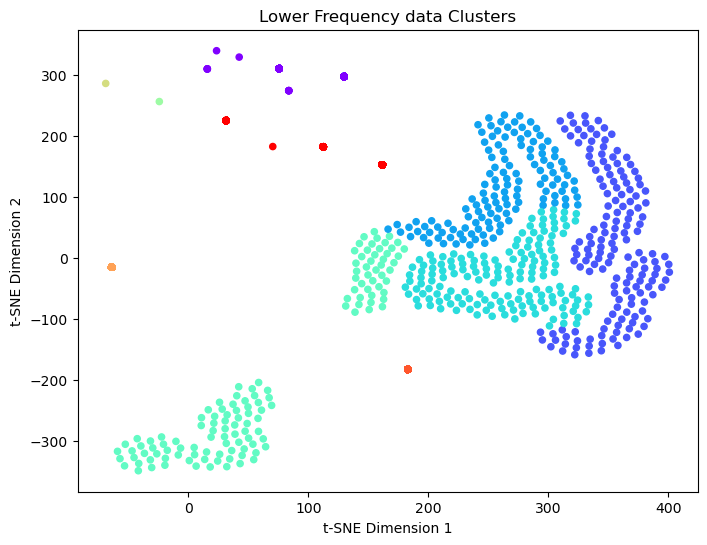

In [301]:
# plot TSNE graph
TSNEplots(lower_frequency_data.copy(),birch_labels_final,"Lower Frequency data Clusters")

### Silhouette Scores

In [304]:
silhouetteScoreAllRawBirch = [] 
calinskiRaw =[]
davies_bouldin_raw =[]
# obtain silhouette Scores for raw data by applying clustering for various number of clusters
for i in range(2, 12): 
    raw_labels_pred = birchfunc(x_train,i)
    silhouetteScoreAllRawBirch.append(silhouetteScore(x_train,raw_labels_pred))
    calinskiRaw.append(calinski_score(x_train,raw_labels_pred))
    davies_bouldin_raw.append(db_score(x_train,raw_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3532791090619684


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 4595.510066284532


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.3789135722248576


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1879831451772538


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 3197.6692861331653


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8304041614179738


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.19888231502242126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2790.919988531779


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8619384536687456


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.20393837995988515


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2418.3571166220827


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.0327382587060763


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.21153913098707894


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2203.1269219421993


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9168872501189604


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1983724831499671


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 2028.2793183338324


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9092645516840467


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2006722206263219


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1852.2246596589362


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8994478351353612


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.0941067338452834


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1721.4703165392389


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.8532997679676564


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1597.112499243934


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.9524809759953623


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08785947340116355


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 1488.9296812366404


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 2.059806054400207


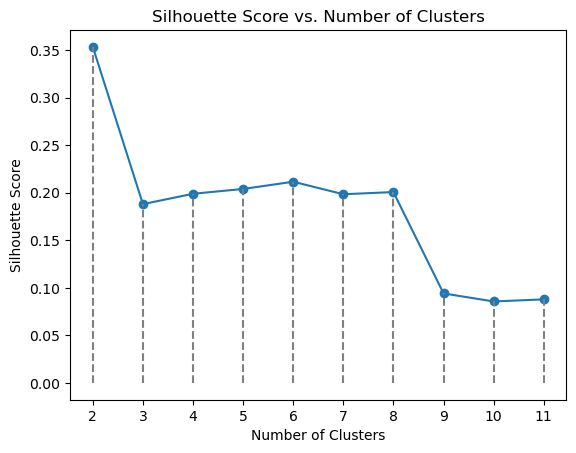

In [305]:
# plot comparison graph

cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllRawBirch, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllRawBirch[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [306]:
silhouetteScoreAllFinalBirch = [] 
calinski_final = []
davies_bouldin_final = []
# obtain silhouette Scores for final processed data by applying clustering for various number of clusters
for i in range(2, 12): 
    final_labels_pred = birchfunc(testing_df,i)
    silhouetteScoreAllFinalBirch.append(silhouetteScore(testing_df,final_labels_pred))
    calinski_final.append(calinski_score(testing_df,final_labels_pred))
    davies_bouldin_final.append(db_score(testing_df,final_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9056144261125789
Calinski-Harabasz Score: 17913.848418334946
Davies-Bouldin Score: 0.6071392011486564


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.904768510263564
Calinski-Harabasz Score: 21881.63044421617
Davies-Bouldin Score: 0.5057952176149065


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8488994297633013
Calinski-Harabasz Score: 19855.577796988575
Davies-Bouldin Score: 0.6712874544724297


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8512600332886231
Calinski-Harabasz Score: 20757.369170236612
Davies-Bouldin Score: 0.7105181638353937


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8546602259252383
Calinski-Harabasz Score: 21505.48735090064
Davies-Bouldin Score: 0.6497066318549826


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8610395936170049
Calinski-Harabasz Score: 21449.374879326213
Davies-Bouldin Score: 0.6189401441050083


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8592265249631151
Calinski-Harabasz Score: 20906.847620808607
Davies-Bouldin Score: 0.6897273829630337


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8552759645558491
Calinski-Harabasz Score: 20717.07124384294
Davies-Bouldin Score: 0.8193738653968533


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8309131451850831
Calinski-Harabasz Score: 20268.863769804502
Davies-Bouldin Score: 0.8593132086693576


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8322023566351907
Calinski-Harabasz Score: 19669.671826437592
Davies-Bouldin Score: 0.7918927217604383


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


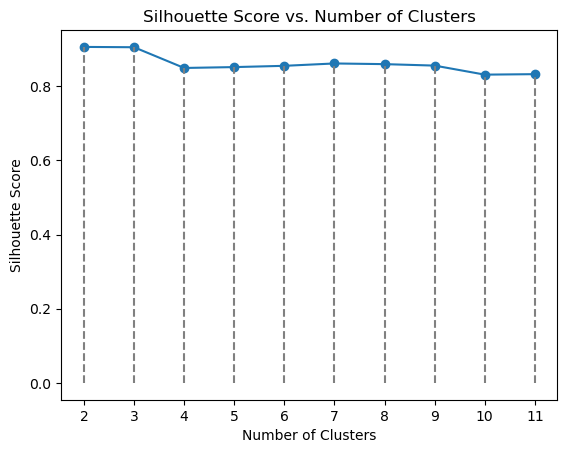

In [307]:
# plot comparison graph

cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllFinalBirch, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllFinalBirch[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

### Comparision

In [308]:
# obtain performance metrics for different number of clusters
raw_scores = silhouetteScoreAllRawBirch[::2]
processed_scores = silhouetteScoreAllFinalBirch[::2]
silhouette_bf = [raw_scores,processed_scores]
calinski_bf  = [calinskiRaw[::2],calinski_final[::2]]
davies_bouldin_bf = [davies_bouldin_raw[::2],davies_bouldin_final[::2]]

x_axis = ["Raw", "After Pre-processing"]
y_axis = ["2 Clusters", "4 Clusters", "6 Clusters", "8 Clusters", "10 Clusters"] 
pd.DataFrame(silhouette_bf, x_axis, y_axis)

2 Clusters  4 Clusters  6 Clusters  8 Clusters  \
Raw                     0.353279    0.198882    0.211539    0.200672   
After Pre-processing    0.905614    0.848899    0.854660    0.859227   

                      10 Clusters  
Raw                      0.085637  
After Pre-processing     0.830913

In [309]:
pd.DataFrame(calinski_bf, x_axis, y_axis)

2 Clusters    4 Clusters    6 Clusters    8 Clusters  \
Raw                    4595.510066   2790.919989   2203.126922   1852.224660   
After Pre-processing  17913.848418  19855.577797  21505.487351  20906.847621   

                       10 Clusters  
Raw                    1597.112499  
After Pre-processing  20268.863770

In [310]:
pd.DataFrame(davies_bouldin_bf, x_axis, y_axis)

2 Clusters  4 Clusters  6 Clusters  8 Clusters  \
Raw                     1.378914    1.861938    1.916887    1.899448   
After Pre-processing    0.607139    0.671287    0.649707    0.689727   

                      10 Clusters  
Raw                      1.952481  
After Pre-processing     0.859313

### DBSCAN

In [311]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=1.0,min_samples=1)
dbs_labels = dbs.fit_predict(lower_frequency_data)

silhouetteScore(lower_frequency_data,dbs_labels)
calinski_score(lower_frequency_data,dbs_labels)
db_score(lower_frequency_data,dbs_labels)
accuracy_metric(y_train,dbs_labels)

Silhouette Score: 0.9705698803245656
Calinski-Harabasz Score: 2837729.3945662174
Davies-Bouldin Score: 0.09832796175192057
Accuracy: 0.35400813092880223


0.35400813092880223

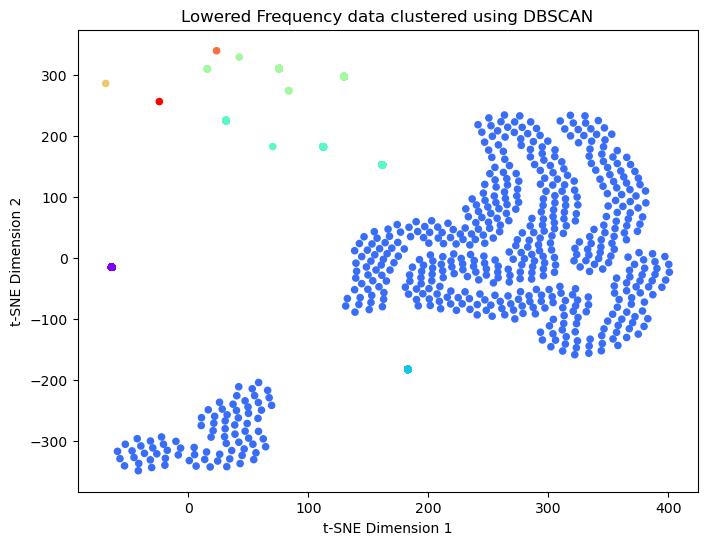

In [312]:
TSNEplots(lower_frequency_data,dbs_labels,"Lowered Frequency data clustered using DBSCAN")

In [313]:
iso_data
dbs = DBSCAN(eps=0.5,min_samples=1)
dbs_labels = dbs.fit_predict(iso_data)

silhouetteScore(iso_data,dbs_labels)
calinski_score(iso_data,dbs_labels)
db_score(iso_data,dbs_labels)
accuracy_metric(y_train,dbs_labels)

Silhouette Score: 0.28595073766148066
Calinski-Harabasz Score: 1174238956.609955
Davies-Bouldin Score: 0.03637163409821264
Accuracy: 0.3699572605024497


0.3699572605024497

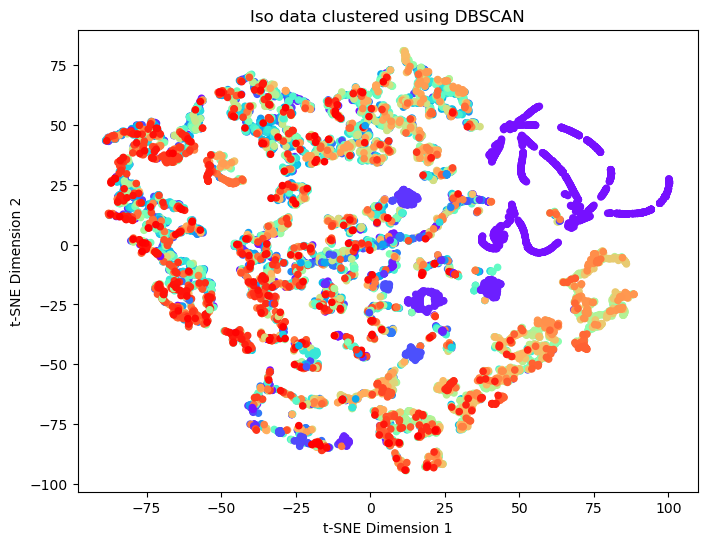

In [314]:
TSNEplots(iso_data,dbs_labels,"Iso data clustered using DBSCAN")